In [44]:
import sys
sys.path.append('..')

from spyral.core.constants import QBRHO_2_P
from spyral.core.run_stacks import form_run_string

from spyral_utils.nuclear import NuclearDataMap
from spyral_utils.nuclear.target import GasTarget, load_target
from spyral_utils.plot import Histogrammer

from pathlib import Path
from scipy.constants import physical_constants, torr
from scipy.integrate import quad
from scipy.stats import iqr
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import vector
import lmfit

%matplotlib widget

In [45]:
# Load data config
workspace_path = Path("c:\\Users\\schaeffe\\Desktop\\e20009_analysis-output\\")
target_material_path = Path("C:\\Users\\schaeffe\\Desktop\\e20009-analysis\\e20009_parameters\\e20009_target.json")

solver_result_path = workspace_path / "InterpSolver"
beam_events_path = workspace_path / "beam_events"

# Run number range (inclusive)
run_min = 108
run_max = 320

# The nucleus we observe (the one fitted)
ejectile_z = 1
ejectile_a = 1

# The incoming nucleus (the beam)
projectile_z = 5
projectile_a = 10

# The target nucleus
target_z = 1
target_a = 2

residual_z = target_z + projectile_z - ejectile_z
residual_a = target_a + projectile_a - ejectile_a

if residual_z < 0:
    raise Exception(f"Illegal nuclei! Residual Z: {residual_z}")
if residual_a < 1:
    raise Exception(f"Illegal nuclei! Residual A: {residual_a}")

In [46]:
# Setup nuclear data objects
nuclear_map = NuclearDataMap()

target_material = load_target(target_material_path, nuclear_map)
if not isinstance(target_material, GasTarget):
    print('Target error!')

ejectile = nuclear_map.get_data(ejectile_z, ejectile_a)
projectile = nuclear_map.get_data(projectile_z, projectile_a)
target = nuclear_map.get_data(target_z, target_a)
residual = nuclear_map.get_data(residual_z, residual_a)
print(f"Reaction: {target}({projectile}, {ejectile}){residual}")
print(f"Target material: {target_material.ugly_string}")

Reaction: 2H(10B, 1H)11B
Target material: (Gas)2H2


In [47]:
# Define parameters used for analysis

proj_energy_start = 106    # Units of MeV. Initial beam energy

min_z = 0.004    # Units of meters. Minimum z value of vertex (inclusive)
max_z = 0.958    # Units of meters. Maximum z value of vertex (inclusive)

min_cm = 12   # Units of degrees. Minimum center-of-mass scattering angle for events in excitation spectrum (inclusive)
max_cm = 36.0   # Units of degrees. Maximum center-of-mass scattering angle for events in excitation spectrum (inclusive)

# # Units of degrees. Events cannot have lab angles in this range because the analysis fails (range is inclusive on both sides)
lab_low = 85
lab_high = 95

hist_en_min = -1      # Smallest allowed excitation energy in histogram (inclusive)
hist_en_max = 29    # Largest allowed excitation energy in histogram (inclusive)
hist_en_bins = 200        # Number of bins in excitation energy histogram

en_range_kev = (hist_en_max - hist_en_min) * 1000 
kev_bin = en_range_kev / hist_en_bins

print(kev_bin)

ang_dist_bins =  12     # Number of bins in angular distribution

150.0


In [48]:
# Define parameters used for finding the cross section

downscale_factor = 1000

ic_min_val = 900
ic_max_val = 1350.0

boltzmann = physical_constants["Boltzmann constant"][0]    # Units of Joules / Kelvin
torr_2_pascal = torr    # Convert from torr to pascals
pressure = 600 # Units of torr
temperature = 273.15    # Units of Kelvin, STP
stoich = 2 # Stoichiometry of gas

In [49]:
# Create dictionary to store results from analysis

results = {}

# Add keys for result parameters
results["polar"] = np.empty(0, float)
results["kinetic_energy"] = np.empty(0, float)
results["ex_energy"] = np.empty(0, float)
results["cm_polar"] = np.empty(0, float)
results["chisq"] = np.empty(0, float)
results["z_vert"] = np.empty(0, float)

# Create histogram tool
grammer = Histogrammer()

In [50]:
# Analysis data

target_vector = vector.array({"px": [0.0], "py": [0.0], "pz": [0.0], "E": [target.mass]})
for run in range(run_min, run_max+1):
    df = None
    path = solver_result_path / f"run_{run:04d}_{ejectile.isotopic_symbol}.parquet"
    if not path.exists():
        continue
    df = pl.scan_parquet(path)

    #Apply gates to data
    df = (df.filter((pl.col("vertex_z") >= min_z) 
                   & (pl.col("vertex_z") <= max_z)
                   & ((pl.col("polar") <= np.deg2rad(lab_low)) | (pl.col("polar") >= np.deg2rad(lab_high)))    # Exclude events near 90 deg
                   )
            .collect()
    )

    # Construct the projectile vectors (beam)
    vertices = df.select(['vertex_x', 'vertex_y', 'vertex_z']).to_numpy()
    distances = np.linalg.norm(vertices, axis=1)
    projectile_ke = proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, distances)
    projectile_vector = vector.array({
        "px": np.zeros(len(projectile_ke)),
        "py": np.zeros(len(projectile_ke)),
        "pz": np.sqrt(projectile_ke * (projectile_ke + 2.0 * projectile.mass)),
        "E": projectile_ke + projectile.mass
    })

    # Construct the ejectile vectors (detected)
    brho = df.select('brho').to_numpy().flatten()
    momentum = df.select('brho').to_numpy().flatten() * float(ejectile.Z) * QBRHO_2_P
    kinetic_energy = np.sqrt(momentum**2.0 + ejectile.mass**2.0) - ejectile.mass
    polar = df.select('polar').to_numpy().flatten()
    az = df.select('azimuthal').to_numpy().flatten()
    ejectile_vector = vector.array({
        "px": momentum * np.sin(polar) * np.cos(az),
        "py": momentum * np.sin(polar) * np.sin(az),
        "pz": momentum * np.cos(polar),
        "E": np.sqrt(momentum**2.0 + ejectile.mass**2.0)
    })

    # Get reduced chi-squared information
    cs = df.select('redchisq').to_numpy().flatten()

    # Get vertex z position
    zvert=df.select('vertex_z').to_numpy().flatten()

    # Do the kinematics
    residual_vector = target_vector + projectile_vector - ejectile_vector # type: ignore
    ex_energy = residual_vector.mass - residual.mass # Excitation energy is "extra" mass

    # Calculate CM scattering angle 
    cm_vec = ejectile_vector.boostCM_of(projectile_vector + target_vector)
    cm_polar = np.pi - cm_vec.theta

    # Fill histograms and arrays
    results["polar"] = np.append(results["polar"], polar)
    results["kinetic_energy"] = np.append(results["kinetic_energy"], kinetic_energy)
    results["ex_energy"] = np.append(results["ex_energy"], ex_energy)
    results["cm_polar"] = np.append(results["cm_polar"], cm_polar)
    results["chisq"] = np.append(results["chisq"], cs)
    results["z_vert"] = np.append(results["z_vert"], zvert)

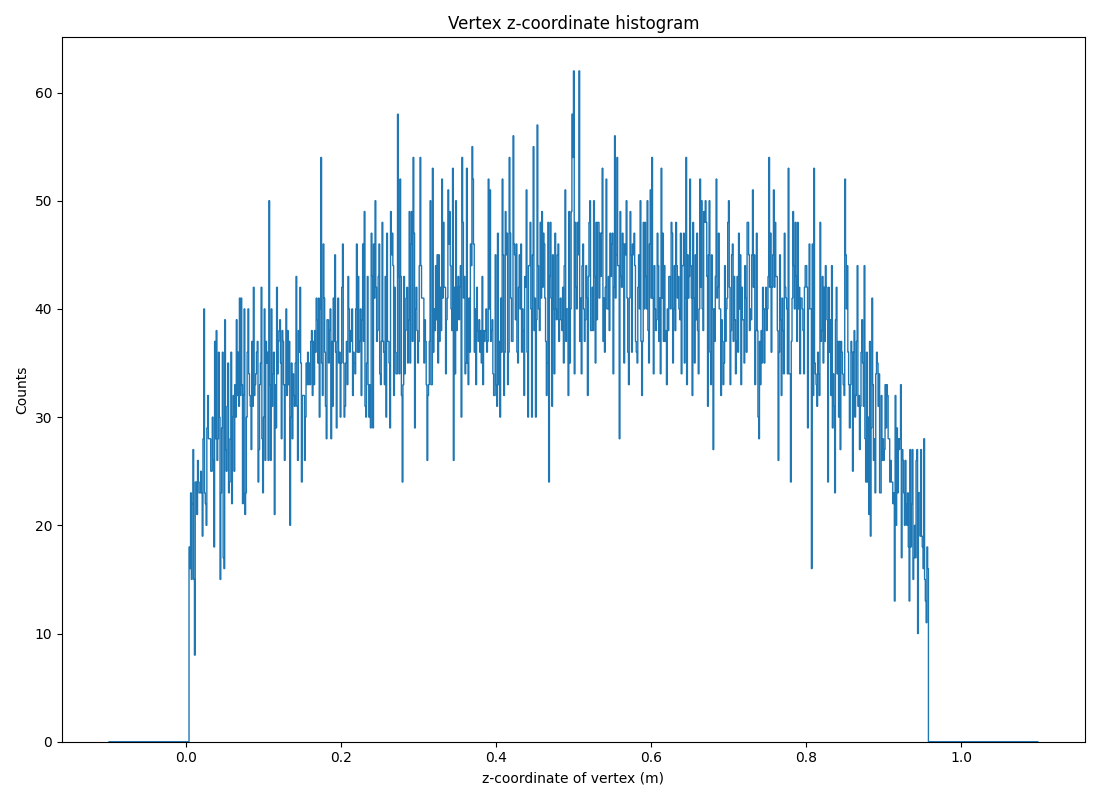

In [51]:
# Plot vertex z-ccordinate histogram

grammer.add_hist1d('z_vert', 1200, (-0.1, 1.1))
grammer.fill_hist1d('z_vert', results["z_vert"])
vertz = grammer.get_hist1d("z_vert")

fig, ax = plt.subplots(1,1)
ax.stairs(vertz.counts, edges=vertz.bins)
ax.set_title(f"Vertex z-coordinate histogram")
ax.set_xlabel("z-coordinate of vertex (m)")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

In [52]:
# Perform analysis of beam events

grammer.add_hist1d('beam_events_ic', 4095, (0.0, 4095.0))

for run in range(run_min, run_max+1):
    df = None
    try:
        path = beam_events_path / f"{form_run_string(run)}.parquet"
        df = pl.read_parquet(path)
    except Exception:
        continue

    # Apply appropriate analysis gates
    df = df.filter((pl.col("ic_multiplicity") == 1)
                 & (pl.col("ic_sca_multiplicity") == 1))
    df = df.filter((abs(pl.col("ic_centroid").list.get(0) - pl.col("ic_sca_centroid").list.get(0)) <= 10))

    ic_amp = df.select(pl.col("ic_amplitude").list.get(0)).to_numpy().flatten()
    grammer.fill_hist1d("beam_events_ic", ic_amp)

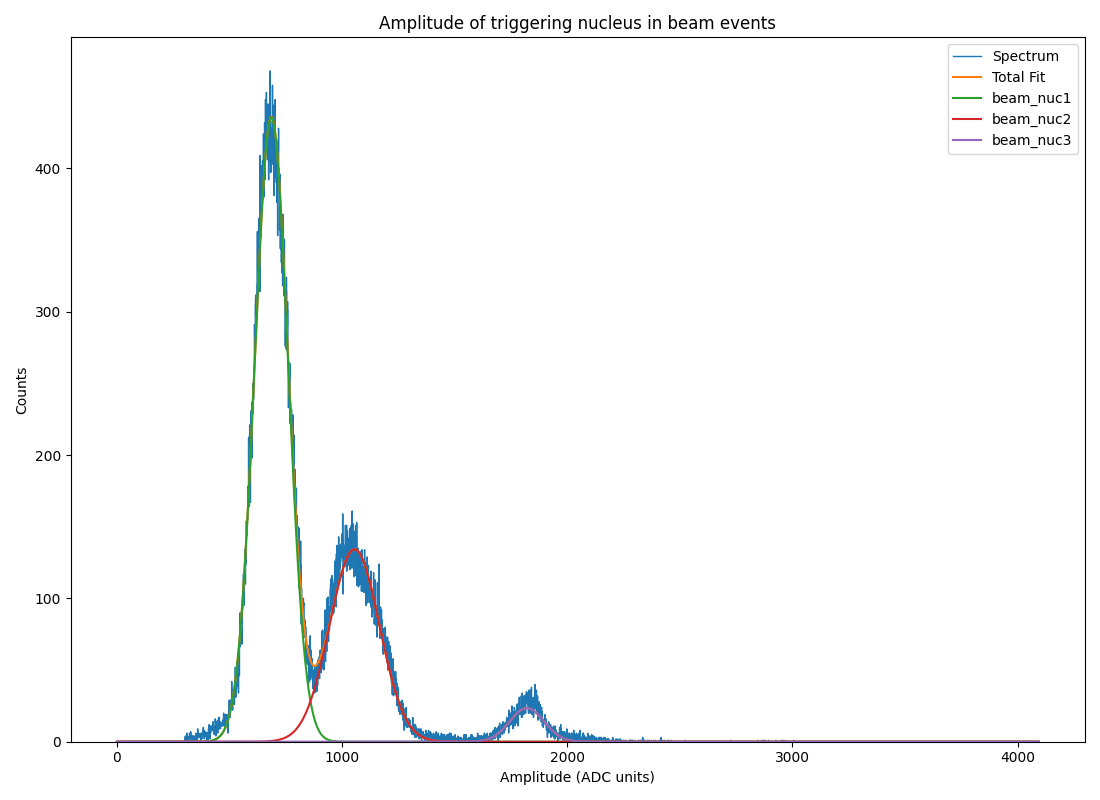

In [53]:
# Plot IC histogram

beam_events_ic = grammer.get_hist1d('beam_events_ic')

beam_nuc1 = lmfit.models.GaussianModel(prefix="beam_nuc1_")
beam_nuc1_bins, beam_nuc1_counts = beam_events_ic.get_subrange((0, ic_min_val))
beam_nuc1_bins += 0.5 * beam_events_ic.bin_width
beam_nuc1_weights = np.sqrt(beam_nuc1_counts)
beam_nuc1_weights = np.divide(1, beam_nuc1_weights, out=np.zeros_like(beam_nuc1_weights), where=beam_nuc1_weights!=0.0)
pars = beam_nuc1.guess(x=beam_nuc1_bins, data=beam_nuc1_counts, weights=beam_nuc1_weights)
pars["beam_nuc1_amplitude"].min = 0.0

beam_nuc2 = lmfit.models.GaussianModel(prefix="beam_nuc2_")
beam_nuc2_bins, beam_nuc2_counts = beam_events_ic.get_subrange((ic_min_val, ic_max_val))
beam_nuc2_weights = np.sqrt(beam_nuc2_counts)
beam_nuc2_weights = np.divide(1, beam_nuc2_weights, out=np.zeros_like(beam_nuc2_weights), where=beam_nuc2_weights!=0.0)
pars.update(beam_nuc2.guess(x=beam_nuc2_bins, data=beam_nuc2_counts, weights=beam_nuc2_weights))
pars["beam_nuc2_amplitude"].min = 0.0

beam_nuc3 = lmfit.models.GaussianModel(prefix="beam_nuc3_")
beam_nuc3_bins, beam_nuc3_counts = beam_events_ic.get_subrange((ic_max_val, 1500))
beam_nuc3_weights = np.sqrt(beam_nuc3_counts)
beam_nuc3_weights = np.divide(1, beam_nuc3_weights, out=np.zeros_like(beam_nuc3_weights), where=beam_nuc3_weights!=0.0)
pars.update(beam_nuc3.guess(x=beam_nuc3_bins, data=beam_nuc3_counts, weights=beam_nuc3_weights))
pars["beam_nuc3_amplitude"].min = 0.0

total_fit = beam_nuc1 + beam_nuc2 +beam_nuc3
total_bins = beam_events_ic.bins[:-1] + beam_events_ic.bin_width/2
total_counts = beam_events_ic.counts
total_weights = np.sqrt(total_counts)
total_weights = np.divide(1, total_weights, out=np.zeros_like(total_weights), where=total_weights!=0.0)
total_result = total_fit.fit(params=pars, x=total_bins, data=total_counts, weights=total_weights)
comps = total_result.eval_components()

fig, ax = plt.subplots(1,1)
ax.stairs(beam_events_ic.counts, edges=beam_events_ic.bins, label="Spectrum")
ax.plot(total_bins, total_result.best_fit, label="Total Fit")
ax.plot(total_bins, comps["beam_nuc1_"], label="beam_nuc1")
ax.plot(total_bins, comps["beam_nuc2_"], label="beam_nuc2")
ax.plot(total_bins, comps["beam_nuc3_"], label="beam_nuc3")
ax.set_title('Amplitude of triggering nucleus in beam events')
ax.set_xlabel('Amplitude (ADC units)')
ax.set_ylabel("Counts")
ax.legend()
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()


In [54]:
# Find counts of beam nucleus

# Find number of contamination counts from neighboring nucleus' peak
A = total_result.params["beam_nuc2_amplitude"].value
mu = total_result.params["beam_nuc2_center"].value
sigma = total_result.params["beam_nuc2_sigma"].value

def gaussian(x, amplitude, center, sigma):
    model = lmfit.models.GaussianModel()
    params = model.make_params(amplitude=amplitude, center=center, sigma=sigma)
    return model.eval(params, x=x)

contamination = quad(gaussian, ic_min_val, ic_max_val, args=(A, mu, sigma))[0] / beam_events_ic.bin_width

# Subtract out contamination from counts
beam_counts, _, _ = beam_events_ic.stats_for_range((ic_min_val, ic_max_val))
beam_counts -= contamination

# Multiply by downscaler
beam_counts *= downscale_factor

In [55]:
# Calculate kinematics for residual particle in given states
proj_energy_stop = proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, np.array([1.0]))[0] # Energy at far end of detector
print(f"Beam energy range: {proj_energy_start}-{proj_energy_stop} MeV")
residual_excitations = np.array([0.0])

# Do the calculation in the center of mass
cm_angle_range = np.linspace(0., np.pi, 1000)
# Calculate envelope from range of beam energies
eject_kinematics = np.zeros((len(residual_excitations), len(cm_angle_range) * 2, 2))

# Upper limit (maximum beam energy)
beam_vec_max = vector.array({
    "px": [0.0],
    "py": [0.0],
    "pz": [np.sqrt(proj_energy_start * (proj_energy_start + 2.0 * projectile.mass))],
    "E": [proj_energy_start + projectile.mass]
})
parent_max = target_vector + beam_vec_max
parent_cm_max = parent_max.boostCM_of(parent_max)
for idx, ex in enumerate(residual_excitations):
    eject_e_cm_max = (ejectile.mass**2.0 - (residual.mass + ex)**2.0 + parent_cm_max.E**2.0) / (2.0 * parent_cm_max.E)
    eject_p_cm_max = np.sqrt(eject_e_cm_max**2.0 - ejectile.mass**2.0)
    eject_vec_cms_max = vector.array({
        "px": eject_p_cm_max * np.sin(cm_angle_range),
        "py": np.zeros(len(cm_angle_range)),
        "pz": eject_p_cm_max * np.cos(cm_angle_range),
        "E": np.full(len(cm_angle_range), eject_e_cm_max)
    })
    eject_vec_lab_max = eject_vec_cms_max.boost(parent_max)
    eject_kinematics[idx, :len(cm_angle_range), 0] = eject_vec_lab_max.theta
    eject_kinematics[idx, :len(cm_angle_range), 1] = eject_vec_lab_max.E - ejectile.mass

# Lower limit (minimum beam energy)
beam_vec_min = vector.array({
    "px": [0.0],
    "py": [0.0],
    "pz": [np.sqrt(proj_energy_stop * (proj_energy_stop + 2.0 * projectile.mass))],
    "E": [proj_energy_stop + projectile.mass]
})
parent_min = target_vector + beam_vec_min
parent_cm_min = parent_min.boostCM_of(parent_min)
for idx, ex in enumerate(residual_excitations):
    eject_e_cm_min = (ejectile.mass**2.0 - (residual.mass + ex)**2.0 + parent_cm_min.E**2.0) / (2.0 * parent_cm_min.E)
    eject_p_cm_min = np.sqrt(eject_e_cm_min**2.0 - ejectile.mass**2.0)
    eject_vec_cms_min = vector.array({
        "px": eject_p_cm_min * np.sin(cm_angle_range),
        "py": np.zeros(len(cm_angle_range)),
        "pz": eject_p_cm_min * np.cos(cm_angle_range),
        "E": np.full(len(cm_angle_range), eject_e_cm_min)
    })
    eject_vec_lab_min = eject_vec_cms_min.boost(parent_min)
    # Note that lower limit is "flipped". We plot the band as a polygon, so need to continue from large lab angles to small lab angles
    eject_kinematics[idx, len(cm_angle_range):, 0] = np.flip(eject_vec_lab_min.theta)
    eject_kinematics[idx, len(cm_angle_range):, 1] = np.flip(eject_vec_lab_min.E - ejectile.mass)

Beam energy range: 106-88.60166000708435 MeV


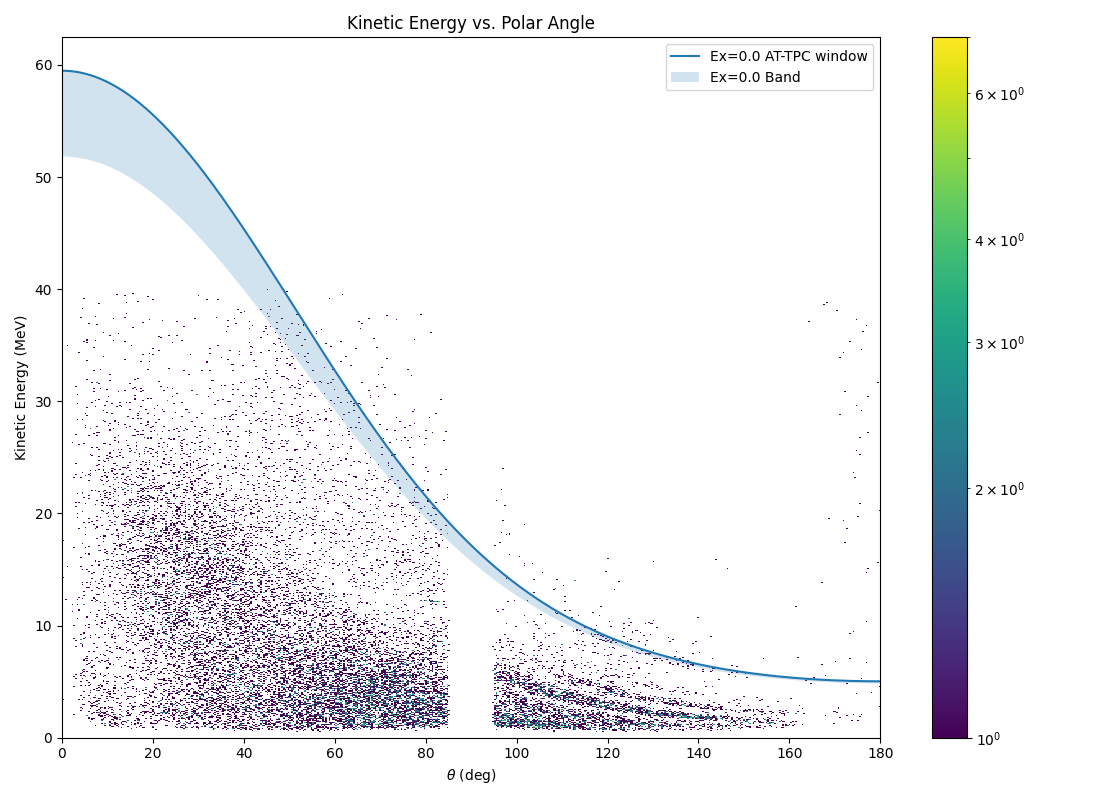

In [56]:
# Plot kinematics from data and compare with theoretical kinematics
grammer.add_hist2d('ke_theta', (500, 800), ((0.0, 180.0), (0.0, 40.0)))
grammer.fill_hist2d('ke_theta', np.rad2deg(results["polar"]), results["kinetic_energy"])
ke_theta = grammer.get_hist2d("ke_theta")

fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(ke_theta.x_bins, ke_theta.y_bins, ke_theta.counts, norm="log")
ax.set_title("Kinetic Energy vs. Polar Angle")
ax.set_xlabel(r"$\theta$ (deg)")
ax.set_ylabel("Kinetic Energy (MeV)")
fig.colorbar(mesh, ax=ax)
for idx, ex in enumerate(residual_excitations):
    ax.plot(np.rad2deg(eject_kinematics[idx, :len(cm_angle_range), 0]), eject_kinematics[idx, :len(cm_angle_range), 1], label=f"Ex={ex:02} AT-TPC window")
    # Fill idea thanks to D. Ramirez
    ax.fill(np.rad2deg(eject_kinematics[idx, :, 0]), eject_kinematics[idx, :, 1], label=f"Ex={ex:02} Band", alpha=0.2)
ax.legend()
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

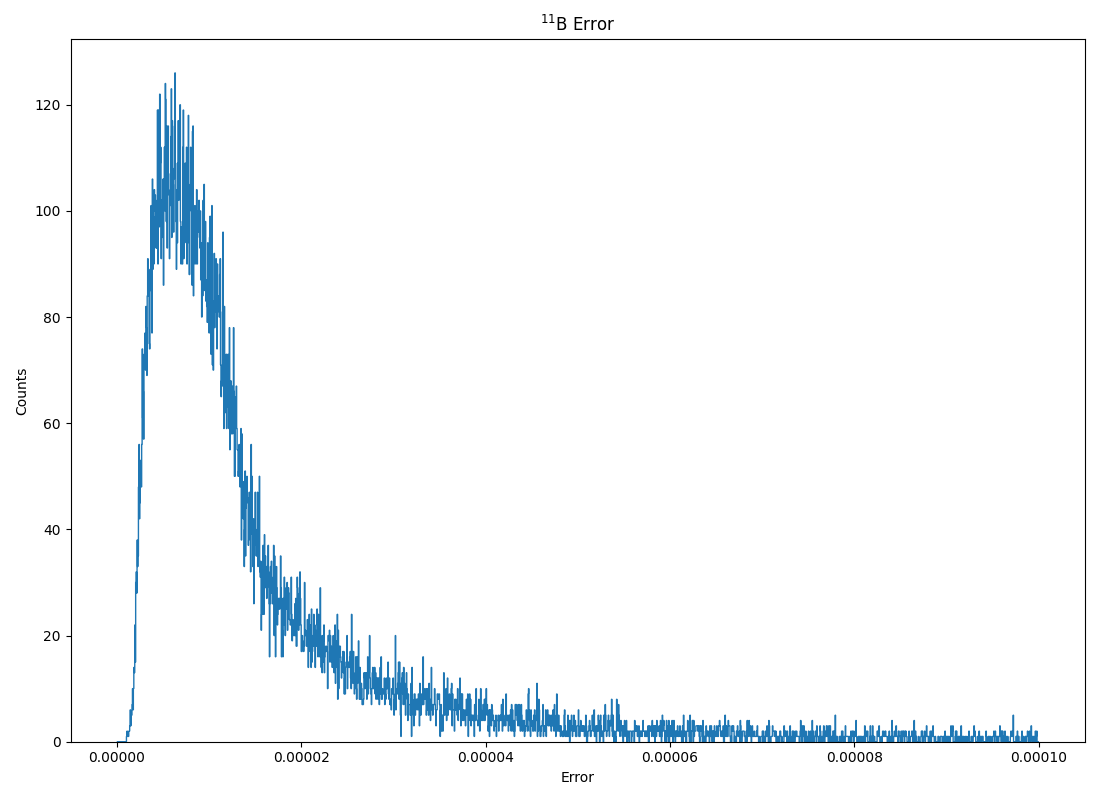

In [57]:
# Plot reduced chi-squared of fits to data

grammer.add_hist1d('chisq', 2000, (0.0, 1e-4))
grammer.fill_hist1d("chisq", results["chisq"])
hist = grammer.get_hist1d("chisq")

fig, ax = plt.subplots(1,1)
ax.stairs(hist.counts, edges=hist.bins)
ax.set_title(f"{residual.get_latex_rep()} Error")
ax.set_xlabel("Error")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

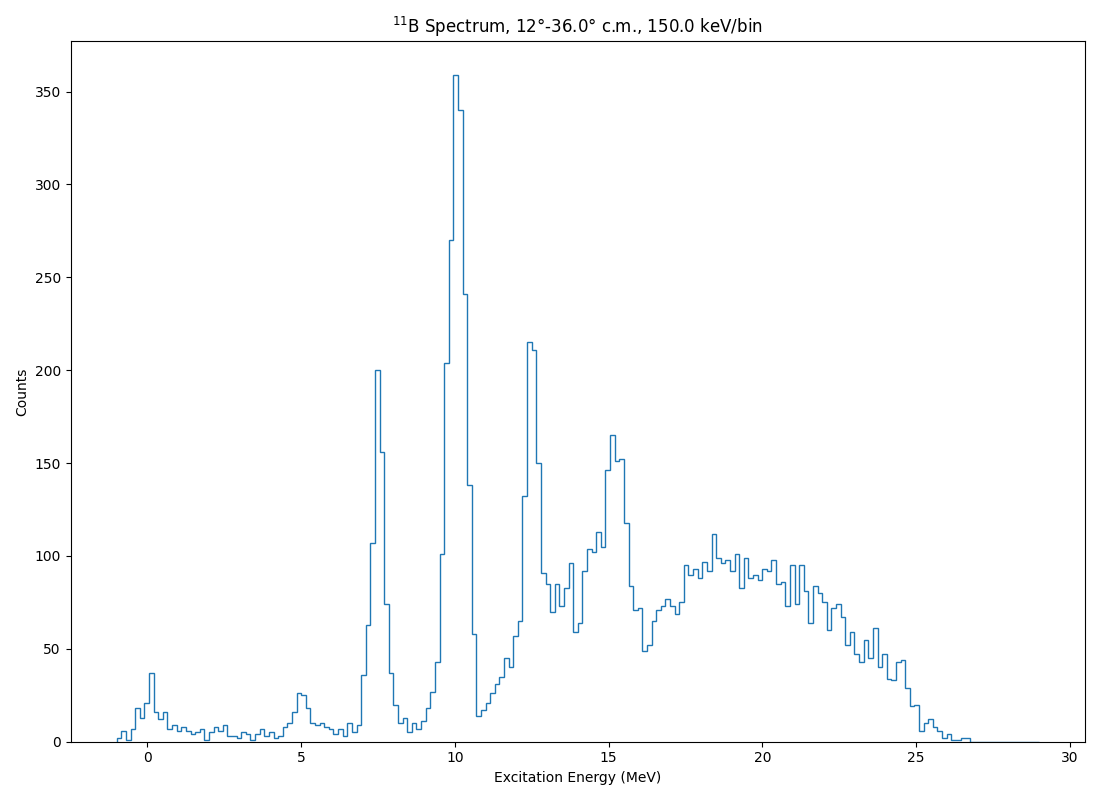

In [58]:
# Plot excitation energy spectrum

# Gate excitation spectrum on CM angle
mask_cm = (np.deg2rad(min_cm) <= results["cm_polar"]) & (results["cm_polar"] <= np.deg2rad(max_cm))    # Make note of inequalites for binning!
ex_energy_gated = results["ex_energy"][mask_cm]

grammer.add_hist1d("ex_energy",hist_en_bins, (hist_en_min, hist_en_max))
grammer.fill_hist1d("ex_energy", ex_energy_gated)

ex_hist = grammer.get_hist1d("ex_energy")
fig, ax = plt.subplots(1,1)
ax.stairs(ex_hist.counts, edges=ex_hist.bins)
ax.set_title(f"{residual.get_latex_rep()} Spectrum, {min_cm}\N{DEGREE SIGN}-{max_cm}\N{DEGREE SIGN} c.m., {kev_bin} keV/bin")
ax.set_xlabel("Excitation Energy (MeV)")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

In [61]:
# print(ex_hist)
print(sum(ex_hist.counts))

10622


In [60]:
print(ex_energy_gated)

np.savetxt("ex_energy_gated_overlap.txt", ex_energy_gated)

[20.07652086 18.61040152 17.98991255 ... 12.41673531 14.54352308
  7.64941261]


In [ ]:
# np.savetxt("C:\\Users\\zachs\\Desktop\\transfer_ex_spect.csv", ex_energy_gated, newline="\n", fmt="%.4f", delimiter=",")

In [ ]:
# Fit excitation spectrum peaks for each angular bin

# Create dictionary to store results of excitation background removal
sub_fits = {}

# Make array of edges of angular cuts
ang_bins = np.linspace(min_cm, max_cm, ang_dist_bins+1)

for idx in range(len(ang_bins) - 1):
    low_edge = ang_bins[idx]
    high_edge = ang_bins[idx+1]

    # Gate excitation spectrum on CM angle
    if idx != (len(ang_bins) - 1):
        mask = (np.deg2rad(low_edge) <= results["cm_polar"]) & (results["cm_polar"] < np.deg2rad(high_edge))    # Make note of inequalites for binning!
    else:
        mask = (np.deg2rad(low_edge) <= results["cm_polar"]) & (results["cm_polar"] <= np.deg2rad(high_edge))    # Make note of inequalites for binning!

    ex_energy_gated = results["ex_energy"][mask]

    # Make and fill histogram
    title = f"ex_energy_{low_edge}-{high_edge}"
    grammer.add_hist1d(title, hist_en_bins, (hist_en_min, hist_en_max))
    grammer.fill_hist1d(title, ex_energy_gated)
    sub_ex_hist = grammer.get_hist1d(title)

    # Fit histogram
    peak1 = lmfit.models.GaussianModel(prefix="peak1_")
    peak1_bins, peak1_counts = sub_ex_hist.get_subrange((-0.1, 0.1))
    peak1_bins += 0.5 * sub_ex_hist.bin_width
    peak1_weights = np.sqrt(peak1_counts)
    peak1_weights = np.divide(1, peak1_weights, out=np.zeros_like(peak1_weights), where=peak1_weights!=0.0)
    pars = peak1.guess(x=peak1_bins, data=peak1_counts, weights=peak1_weights)
    pars["peak1_amplitude"].min = 0.0
    pars["peak1_center"].min = 0.0
    pars["peak1_center"].max = 0.08

    peak2 = lmfit.models.GaussianModel(prefix="peak2_")
    peak2_bins, peak2_counts = sub_ex_hist.get_subrange((0.2, 0.4))
    peak2_bins += 0.5 * sub_ex_hist.bin_width
    peak2_weights = np.sqrt(peak2_counts)
    peak2_weights = np.divide(1, peak2_weights, out=np.zeros_like(peak2_weights), where=peak2_weights!=0.0)
    pars.update(peak2.guess(x=peak2_bins, data=peak2_counts, weights=peak2_weights))
    pars["peak2_amplitude"].min = 0.0
    pars["peak2_center"].min = 0.2
    pars["peak2_center"].max = 0.4
    pars["peak2_sigma"].set(expr="peak1_sigma", vary=False)

    peak3 = lmfit.models.VoigtModel(prefix="peak3_")
    peak3_bins, peak3_counts = sub_ex_hist.get_subrange((1.2, 2.2))
    peak3_bins += 0.5 * sub_ex_hist.bin_width
    peak3_weights = np.sqrt(peak3_counts)
    peak3_weights = np.divide(1, peak3_weights, out=np.zeros_like(peak3_weights), where=peak3_weights!=0.0)
    pars.update(peak3.guess(x=peak3_bins, data=peak3_counts, weights=peak3_weights))
    pars["peak3_amplitude"].min = 0.0
    pars["peak3_center"].min = 1.2
    pars["peak3_center"].max = 2.2

    peak4 = lmfit.models.VoigtModel(prefix="peak4_")
    peak4_bins, peak4_counts = sub_ex_hist.get_subrange((2.4, 2.8))
    peak4_bins += 0.5 * sub_ex_hist.bin_width
    peak4_weights = np.sqrt(peak4_counts)
    peak4_weights = np.divide(1, peak4_weights, out=np.zeros_like(peak4_weights), where=peak4_weights!=0.0)
    pars.update(peak4.guess(x=peak4_bins, data=peak4_counts, weights=peak4_weights))
    pars["peak4_amplitude"].min = 0.0
    pars["peak4_center"].min = 2.3
    pars["peak4_center"].max = 2.8
    pars["peak4_sigma"].set(expr="peak3_sigma", vary=False)

    peak5 = lmfit.models.VoigtModel(prefix="peak5_")
    peak5_bins, peak5_counts = sub_ex_hist.get_subrange((3.2, 3.6))
    peak5_bins += 0.5 * sub_ex_hist.bin_width
    peak5_weights = np.sqrt(peak5_counts)
    peak5_weights = np.divide(1, peak5_weights, out=np.zeros_like(peak5_weights), where=peak5_weights!=0.0)
    pars.update(peak5.guess(x=peak5_bins, data=peak5_counts, weights=peak5_weights))
    pars["peak5_amplitude"].min = 0.0
    pars["peak5_center"].min = 3.1
    pars["peak5_center"].max = 3.6
    pars["peak5_sigma"].set(expr="peak3_sigma", vary=False)

    bkgd = lmfit.models.VoigtModel(prefix="bkgd_")
    bkgd_bins, bkgd_counts = sub_ex_hist.get_subrange((3.8, 4.3))
    bkgd_bins += 0.5 * sub_ex_hist.bin_width
    bkgd_weights = np.sqrt(bkgd_counts)
    bkgd_weights = np.divide(1, bkgd_weights, out=np.zeros_like(bkgd_weights), where=bkgd_weights!=0.0)
    pars.update(bkgd.guess(x=bkgd_bins, data=bkgd_counts, weights=bkgd_weights))
    pars["bkgd_amplitude"].min = 0.0
    pars["bkgd_center"].min = 3.8
    pars["bkgd_center"].max = 4.3
    pars["bkgd_sigma"].set(expr="peak3_sigma", vary=False)

    total_fit = peak1 + peak2 + peak3 + peak4 + peak5 + bkgd
    total_bins = sub_ex_hist.bins[:-1] + sub_ex_hist.bin_width/2
    total_counts = sub_ex_hist.counts
    total_weights = np.sqrt(total_counts)
    total_weights = np.divide(1, total_weights, out=np.zeros_like(total_weights), where=total_weights!=0.0)
    total_result = total_fit.fit(params=pars, x=total_bins, data=total_counts, weights=total_weights)

    # Store total fit result
    sub_fits[title] = total_result

In [ ]:
# Index for checking fit results
idx = -1

In [ ]:
# Check results of the fits

idx += 1
low_edge = ang_bins[idx]
high_edge = ang_bins[idx+1]
title = f"ex_energy_{low_edge}-{high_edge}"

# Get results of fit
sub_fit_result = sub_fits[title]
comps = sub_fit_result.eval_components()

# Plot result
fig, ax = plt.subplots(1,1)
sub_ex_hist = grammer.get_hist1d(title)
ax.stairs(sub_ex_hist.counts, edges=sub_ex_hist.bins, label="Spectrum")
ax.plot(total_bins, sub_fit_result.best_fit, label="Total Fit")
ax.plot(total_bins, comps["peak1_"], label="peak1")
ax.plot(total_bins, comps["peak2_"], label="peak2")
ax.plot(total_bins, comps["peak3_"], label="peak3")
ax.plot(total_bins, comps["peak4_"], label="peak4")
ax.plot(total_bins, comps["peak5_"], label="peak5")
ax.plot(total_bins, comps["bkgd_"], label="bkgd")
ax.set_title(f"{residual.get_latex_rep()} Spectrum, {low_edge}\N{DEGREE SIGN}-{high_edge}\N{DEGREE SIGN} c.m.")
ax.set_xlabel("Excitation Energy (MeV)")
ax.set_ylabel("Counts")
ax.legend()
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

In [ ]:
# Calculate efficiency factors

# Parameters
eff_sim_events_path = Path("E:\\final\\dp_2.65\\workspace\\InterpSolver")
kine_path = Path("E:\\final\\dp_2.65\\dp_2.65_kine.parquet")
run_min_eff = 0
run_max_eff = 29

# Store results
results_eff = {}
results_eff["cm_polar"] = np.empty(0, float)
results_eff["ex_energy"] = np.empty(0, float)
results_eff["event"] = np.empty(0, int)
results_eff["chisq"] = np.empty(0, float)

for run in range(run_min_eff, run_max_eff+1):
    df = None
    path = eff_sim_events_path / f"run_{run:04d}_{ejectile.isotopic_symbol}.parquet"
    if not path.exists():
        print(f"Run {run} does have a solver file!")
        continue
    df = pl.scan_parquet(path)

    #Apply gates to data
    df = (df.filter((pl.col("vertex_z") >= min_z) 
                   & (pl.col("vertex_z") <= max_z)
                #    & ((pl.col("polar") <= np.deg2rad(lab_low)) | (pl.col("polar") >= np.deg2rad(lab_high)))    # Exclude events near 90 deg
                   )
            .collect()
    )

    # Construct the projectile vectors (beam)
    vertices = df.select(['vertex_x', 'vertex_y', 'vertex_z']).to_numpy()
    distances = np.linalg.norm(vertices, axis=1)
    projectile_ke = proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, distances)
    projectile_vector = vector.array({
        "px": np.zeros(len(projectile_ke)),
        "py": np.zeros(len(projectile_ke)),
        "pz": np.sqrt(projectile_ke * (projectile_ke + 2.0 * projectile.mass)),
        "E": projectile_ke + projectile.mass
    })

    # Construct the ejectile vectors (detected)
    brho = df.select('brho').to_numpy().flatten()
    momentum = df.select('brho').to_numpy().flatten() * float(ejectile.Z) * QBRHO_2_P
    kinetic_energy = np.sqrt(momentum**2.0 + ejectile.mass**2.0) - ejectile.mass
    polar = df.select('polar').to_numpy().flatten()
    az = df.select('azimuthal').to_numpy().flatten()
    ejectile_vector = vector.array({
        "px": momentum * np.sin(polar) * np.cos(az),
        "py": momentum * np.sin(polar) * np.sin(az),
        "pz": momentum * np.cos(polar),
        "E": np.sqrt(momentum**2.0 + ejectile.mass**2.0)
    })

    # Calculate CM scattering angle 
    cm_vec = ejectile_vector.boostCM_of(projectile_vector + target_vector)
    cm_polar = np.pi - cm_vec.theta

    # Do the kinematics
    residual_vector = target_vector + projectile_vector - ejectile_vector # type: ignore
    ex_energy = residual_vector.mass - residual.mass # Excitation energy is "extra" mass

    # Get reduced chi-squared information
    cs = df.select('redchisq').to_numpy().flatten()

    # Event number
    ev_num = df.select("event").to_numpy()

    # Fill array
    results_eff["cm_polar"] = np.append(results_eff["cm_polar"], cm_polar)
    results_eff["ex_energy"] = np.append(results_eff["ex_energy"], ex_energy)
    results_eff["event"] = np.append(results_eff["event"], ev_num)
    results_eff["chisq"] = np.append(results_eff["chisq"], cs)

# Histogram of all simulated CM angles that made it through analysis
grammer.add_hist1d("cm_polar_sim_analysis", ang_dist_bins, (min_cm, max_cm))
grammer.fill_hist1d("cm_polar_sim_analysis", np.rad2deg(results_eff["cm_polar"]))
sim_analysis = grammer.get_hist1d("cm_polar_sim_analysis")

# Histogram of all simulated CM angles from kinematics file
kine_f = pl.scan_parquet(kine_path)

beam_coords = (
    kine_f.filter((pl.col("Z") == projectile.Z) & (pl.col("A") == projectile.A))
    .select("px", "py", "pz", "energy")
    .collect()
    .to_numpy()
)
beam_vectors = vector.array(
    {
        "px": beam_coords[:, 0],
        "py": beam_coords[:, 1],
        "pz": beam_coords[:, 2],
        "E": beam_coords[:, 3],
    }
)
product_coords = (
    kine_f.filter((pl.col("Z") == residual.Z) & (pl.col("A") == residual.A))
    .select("px", "py", "pz", "energy")
    .collect()
    .to_numpy()
)
product_vectors = vector.array(
    {
        "px": product_coords[:, 0],
        "py": product_coords[:, 1],
        "pz": product_coords[:, 2],
        "E": product_coords[:, 3],
    }
)

cm_ang_sim_all = product_vectors.boostCM_of(beam_vectors + target_vector).theta
grammer.add_hist1d("cm_polar_sim_all", ang_dist_bins, (min_cm, max_cm))
grammer.fill_hist1d("cm_polar_sim_all", np.rad2deg(cm_ang_sim_all))
sim_all = grammer.get_hist1d("cm_polar_sim_all")

# Calculate efficiency factors
eff_factors = sim_all.counts/sim_analysis.counts
eff_factors_err = eff_factors * np.sqrt(1 / sim_all.counts + 1 / sim_analysis.counts)

In [ ]:
# Find angle error from simulations

# Make LazyFrame of all simulated events' cm angle and their event number
cm_sim_f = pl.LazyFrame({"event": kine_f.gather_every(4).select("event").collect().to_numpy().flatten(), "cm_angle": cm_ang_sim_all})

# Store angle error
cm_err = np.zeros(ang_dist_bins, dtype=float)

for idx in range(len(ang_bins) - 1):
    low_edge = ang_bins[idx]
    high_edge = ang_bins[idx+1]

    # Gate excitation spectrum on CM angle
    if idx != (len(ang_bins) - 1):
        mask_x = (np.deg2rad(low_edge) <= results_eff["cm_polar"]) & (results_eff["cm_polar"] < np.deg2rad(high_edge))    # Make note of inequalites for binning!
    else:
        mask_x = (np.deg2rad(low_edge) <= results_eff["cm_polar"]) & (results_eff["cm_polar"] <= np.deg2rad(high_edge))    # Make note of inequalites for binning!

    # Find events with multiple analyzed tracks
    mult_sort, mult_count = np.unique(results_eff["event"][mask_x], return_counts=True)

    # Add events back in
    events_in_bin = np.empty(0, float)
    for mult in range(1, np.max(mult_count)+1):
        events_in_bin_mult = cm_sim_f.filter(pl.col("event").is_in(mult_sort[mult_count==mult])).select("cm_angle").collect().to_numpy().flatten()
        events_in_bin = np.append(events_in_bin, events_in_bin_mult)

    cm_err[idx] = np.rad2deg(iqr(events_in_bin))/2

In [ ]:
# Find CM scattering angle histogram

cm_counts = np.zeros(ang_dist_bins, dtype=int)

def voigt(x, amplitude, center, sigma, gamma):
    model = lmfit.models.VoigtModel()
    params = model.make_params(amplitude=amplitude, center=center, sigma=sigma, gamma=gamma)
    return model.eval(params, x=x)

# Use for Voigt states
for idx, fit in enumerate(sub_fits.items()):
    amplitude = fit[1].params["peak4_amplitude"].value
    center= fit[1].params["peak4_center"].value
    sigma = fit[1].params["peak4_sigma"].value
    gamma = fit[1].params["peak4_gamma"].value
    cm_counts[idx] = quad(voigt, hist_en_min, hist_en_max, args=(amplitude, center, sigma, gamma))[0] / ex_hist.bin_width

# # Use for Gaussian states
# for idx, fit in enumerate(sub_fits.items()):
#     amplitude = fit[1].params["peak1_amplitude"].value
#     center= fit[1].params["peak1_center"].value
#     sigma = fit[1].params["peak1_sigma"].value
#     cm_counts[idx] = quad(gaussian, hist_en_min, hist_en_max, args=(amplitude, center, sigma))[0] / ex_hist.bin_width

grammer.add_hist1d("cm_polar", ang_dist_bins, (min_cm, max_cm))
cm_hist = grammer.get_hist1d("cm_polar")
cm_hist.counts = cm_counts

In [ ]:
# Calculate cross section

length = 1    # Units of meters
nuclei_areal_density = pressure * torr_2_pascal * length / boltzmann / temperature * stoich * 1.0e-31 # Units of target nuclei / millibarns

# Without efficiency correction
# xs = cm_hist.counts  / np.diff(np.cos(np.deg2rad(cm_hist.bins))) / (-2 * np.pi * beam_counts * nuclei_areal_density)   # Units of millibarns / steradians
# xs_err = np.sqrt(cm_hist.counts) / np.diff(np.cos(np.deg2rad(cm_hist.bins))) / (-2 * np.pi * beam_counts * nuclei_areal_density)

# With effiency correction
xs = cm_hist.counts * eff_factors  / np.diff(np.cos(np.deg2rad(cm_hist.bins))) / (-2 * np.pi * beam_counts * nuclei_areal_density)   # Units of millibarns / steradians
xs_err = np.sqrt((eff_factors * np.sqrt(cm_hist.counts))**2 + (cm_hist.counts * eff_factors_err)**2) / np.diff(np.cos(np.deg2rad(cm_hist.bins))) / (-2 * np.pi * beam_counts * nuclei_areal_density)

In [ ]:
# Plot angular distribution

# Ptolemy DWBA calculations
es3_l1 = pl.read_csv("D:\\ptolemy\\11Be\\3.4_mev\\l1\\beam_93mev.csv")
es3_l1_93 = es3_l1.to_dict(as_series=True)
es3_l2 = pl.read_csv("D:\\ptolemy\\11Be\\3.4_mev\\l2\\beam_93mev.csv")
es3_l2_93 = es3_l2.to_dict(as_series=True)
es2_l2 = pl.read_csv("D:\\ptolemy\\11Be\\1.78_mev\\l2\\beam_93mev.csv")
es2_l2_93 = es2_l2.to_dict(as_series=True)
es2_l1 = pl.read_csv("D:\\ptolemy\\11Be\\1.78_mev\\l1\\beam_93mev.csv")
es2_l1_93 = es2_l1.to_dict(as_series=True)

fig, ax = plt.subplots(1,1)
ax.errorbar(cm_hist.bins[:-1]+cm_hist.bin_width/2, xs, yerr=xs_err, xerr=cm_err, fmt='o', label="This experiment")

# ax.plot(es3_l1_93['cm_angle'],es3_l1_93['xs_mb']*0.392, label="ℓ=1, S=0.392")
# ax.plot(es3_l2_93['cm_angle'],es3_l2_93['xs_mb']*0.176, label="ℓ=2, S=0.176")
# ax.plot(es2_l1_93['cm_angle'],es2_l1_93['xs_mb']*1.716, label="ℓ=1, S=1.716")
# ax.plot(es2_l2_93['cm_angle'],es2_l2_93['xs_mb']*.627, label="ℓ=2, S=0.627")

# ax.set_title("1.78 MeV state")
ax.set_xlabel(r"$\theta_{c.m.}$ (deg)")
ax.set_ylabel(r"$d\sigma / d\Omega_{c.m.}$ (mb / sr)")
ax.legend()
plt.xlim(min_cm, max_cm)
plt.ylim(0,20)
fig.set_figwidth(8.0)
fig.set_figwidth(6.0)
fig.tight_layout()

In [ ]:
# np.savetxt("C:\\Users\\zachs\\Desktop\\2.65_xs_bb.csv", np.array([cm_hist.bins[:-1]+cm_hist.bin_width/2, cm_err, xs, xs_err]).T, newline="\n", fmt="%.4f", delimiter=",", header="ang(deg),ang_err,xs(mb),xs_err", comments="")

In [ ]:
# Spectroscopic factor extraction

l1 = lambda x, A: A * np.interp(x, es3_l1_93["cm_angle"], es3_l1_93["xs_mb"])
l2 = lambda x, A: A * np.interp(x, es3_l2_93["cm_angle"], es3_l2_93["xs_mb"])

params = lmfit.Parameters()

shape = lmfit.Model(l1)
params.add("A", value=1, min=0)

fit_weights = np.sqrt(xs)
fit_weights = np.divide(1, fit_weights, out=np.zeros_like(fit_weights), where=fit_weights!=0.0)
total_result = shape.fit(params=params, x=cm_hist.bins[:-1]+cm_hist.bin_width/2, data=xs, weights=fit_weights)

total_result